In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import psycopg2

# PROJECT: CUSTOMER BEHAVIOR ANALYSIS

Suppose we want to understand customer preferences in order to update the company's marketing strategy. For instance, in an ideal business case scenario, identifying frequently rented movie genres allows us to tailor movie collections and promotions to align with customer interests. To achieve this, we will craft a query that retrieves movie genres, their rental frequencies, and customer demographic information, allowing us to strategize effectively. The resulting table will include a column for each of the following: movie genre, total number of rentals per genre, percentage of total rentals represented by each genre, and average customer age within each genre category. This comprehensive table will provide insights into customer genre preferences and demographics, enabling us to make informed decisions regarding our movie offerings and promotional strategies.

```sql
--I used the column created_at(customer.created_t) as the age of the customer, which is totally false
WITH GenreRentals AS (
    SELECT
        c.customer_id,
        fc.category_id,
        COUNT(r.rental_id) AS rental_count
    FROM
        rental r
    JOIN
        inventory i ON r.inventory_id = i.inventory_id
    JOIN
        film f ON i.film_id = f.film_id
    JOIN
        customer c ON r.customer_id = c.customer_id
    JOIN
        film_category fc ON f.film_id = fc.film_id
    GROUP BY
        c.customer_id,
        fc.category_id
)
SELECT
    gr.category_id,
    cat.name AS movie_genre,
    SUM(gr.rental_count) AS total_rentals_per_genre,
    ROUND(SUM(gr.rental_count) * 100.0 / (SELECT COUNT(*) FROM rental), 2) AS percentage_of_total_rentals,
    AVG(EXTRACT(YEAR FROM AGE(c.create_date))) AS average_customer_age
FROM
    GenreRentals gr
JOIN
    category cat ON gr.category_id = cat.category_id
JOIN
    customer c ON gr.customer_id = c.customer_id
GROUP BY
    gr.category_id,
    cat.name
ORDER BY
    total_rentals_per_genre DESC;
```


Below is a function that uses the table above to create a visualization as explained above: 

/tmp/ipykernel_16215/798292235.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


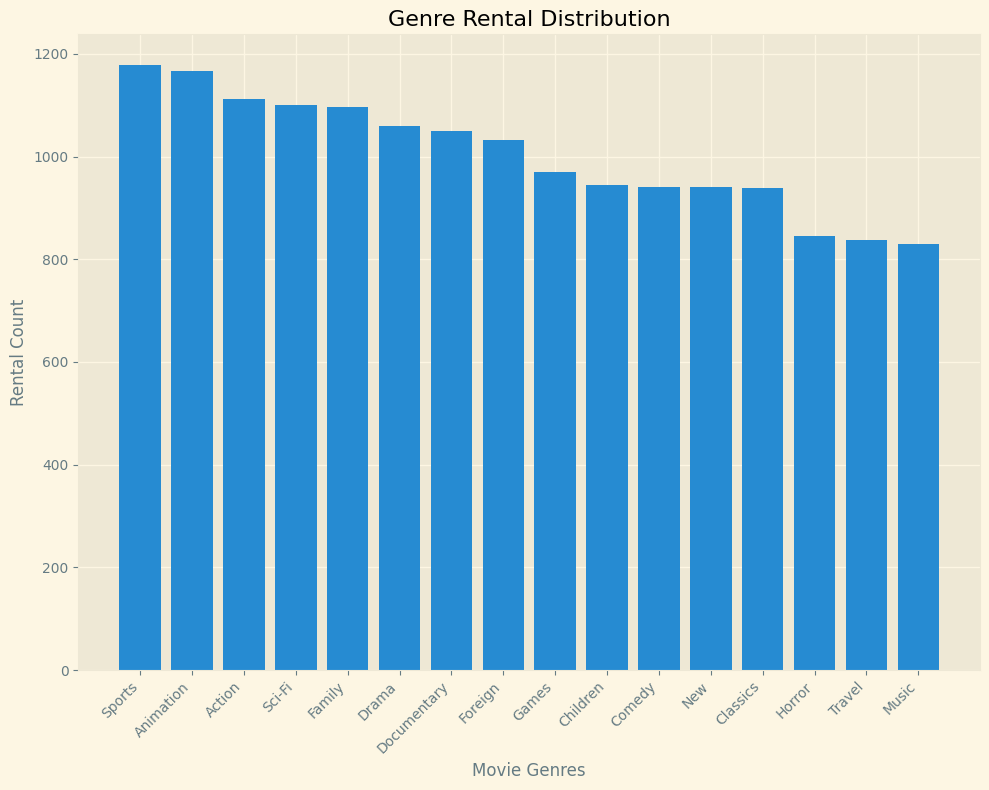

In [6]:
def analyze_genre_rental_distribution(conn):
    # SQL query to retrieve the data
    query = """
    WITH GenreRentals AS (
        SELECT
            fc.category_id,
            COUNT(r.rental_id) AS rental_count
        FROM
            rental r
        JOIN
            inventory i ON r.inventory_id = i.inventory_id
        JOIN
            film f ON i.film_id = f.film_id
        JOIN
            film_category fc ON f.film_id = fc.film_id
        GROUP BY
            fc.category_id
    )
    SELECT
        cat.name AS movie_genre,
        gr.rental_count
    FROM
        GenreRentals gr
    JOIN
        category cat ON gr.category_id = cat.category_id
    ORDER BY
        rental_count DESC;
    """

    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)

    # Set the plot style to "Solarize_Light2"
    style.use("Solarize_Light2")

    # Visualization: Genre Rental Distribution (Bar Chart)
    plt.figure(figsize=(10, 8))
    plt.bar(df['movie_genre'], df['rental_count'])
    plt.xlabel('Movie Genres')
    plt.ylabel('Rental Count')
    plt.title('Genre Rental Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",  # Use the correct user name (not "root")
    password="root",  # Use the correct password (not "root")
    host="postgres",  # This should be the service name in your Docker Compose network
    port="5432"
)

# Call the function to analyze genre rental distribution and visualize the results
analyze_genre_rental_distribution(conn)

# Close the database connection
conn.close()

Analyzing the distribution of rental counts across different movie genres. This can provide insights into which genres are rented more frequently or less frequently compared to others. generate a bar chart visualization that shows the rental count for each movie genre. The x-axis will display the movie genres, and the y-axis will show the corresponding rental counts. This visualization will help you identify which genres are more popular in terms of rental frequency and which genres are less frequently rented by customers.

/tmp/ipykernel_16215/1756280930.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_distribution = pd.read_sql_query(query, conn)


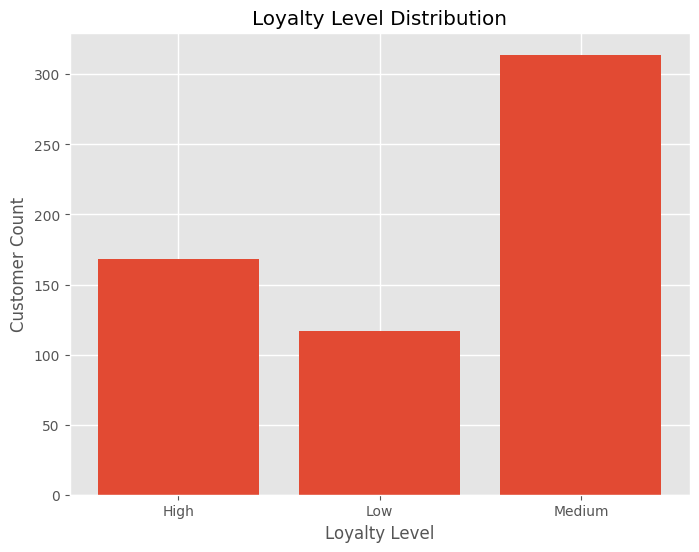

In [13]:
def visualize_loyalty_level_distribution(conn):
    query = """
    WITH CustomerLoyalty AS (
        SELECT
            c.customer_id,
            COUNT(r.rental_id) AS rental_count,
            SUM(p.amount) AS total_payments
        FROM
            customer c
        LEFT JOIN
            rental r ON c.customer_id = r.customer_id
        LEFT JOIN
            payment p ON c.customer_id = p.customer_id
        GROUP BY
            c.customer_id
    ),
    LoyaltyLevels AS (
        SELECT
            customer_id,
            rental_count,
            total_payments,
            CASE
                WHEN rental_count >= 800 AND total_payments >= 2500 THEN 'High'
                WHEN rental_count >= 450 AND total_payments >= 1500 THEN 'Medium'
                ELSE 'Low'
            END AS loyalty_level
        FROM
            CustomerLoyalty
    )
    SELECT
        ll.loyalty_level,
        COUNT(*) AS customer_count
    FROM
        LoyaltyLevels ll
    GROUP BY
        ll.loyalty_level;
    """

    # Execute the query and fetch the results using pandas
    df_distribution = pd.read_sql_query(query, conn)
    style.use("ggplot")

    # Visualization: Loyalty Level Distribution (Bar Chart)
    plt.figure(figsize=(8, 6))
    plt.bar(df_distribution['loyalty_level'], df_distribution['customer_count'])
    plt.xlabel('Loyalty Level')
    plt.ylabel('Customer Count')
    plt.title('Loyalty Level Distribution')
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function to visualize loyalty level distribution
visualize_loyalty_level_distribution(conn)

# Close the database connection
conn.close()



What about if we want to uncover the rental behavior of customers based on different days of the week? if we can achieve this, then we can examine whether customers exhibit specific preferences for certain days, which is useful in real-world business environment for purposes such as optimizing inventory management or staff scheduling. To achieve this, we can create a query that aggregates rental data by day of the week and calculates average rentals. The resulting table will include a column for each of the following: the day of the week, the average number of rentals, and a trend indicator highlighting whether a particular day exhibits higher or lower rental activity compared to the overall average.

```sql
WITH DayOfWeekRental AS (
    SELECT
        DATE_PART('dow', r.rental_date) AS day_of_week,
        COUNT(r.rental_id) AS rental_count
    FROM
        rental r
    GROUP BY
        DATE_PART('dow', r.rental_date)
),
OverallAverage AS (
    SELECT
        AVG(rental_count) AS average_rental_count
    FROM
        DayOfWeekRental
)
SELECT
    d.day_of_week,
    d.rental_count,
    CASE
        WHEN d.rental_count > o.average_rental_count THEN 'Higher'
        WHEN d.rental_count < o.average_rental_count THEN 'Lower'
        ELSE 'Equal'
    END AS trend_indicator
FROM
    DayOfWeekRental d
CROSS JOIN
    OverallAverage o
ORDER BY
    d.day_of_week;
```
Below is a function that shows how we can use the table above to visualize weekly trends and insights and get a better understanding of the data: 

/tmp/ipykernel_16215/2264924241.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


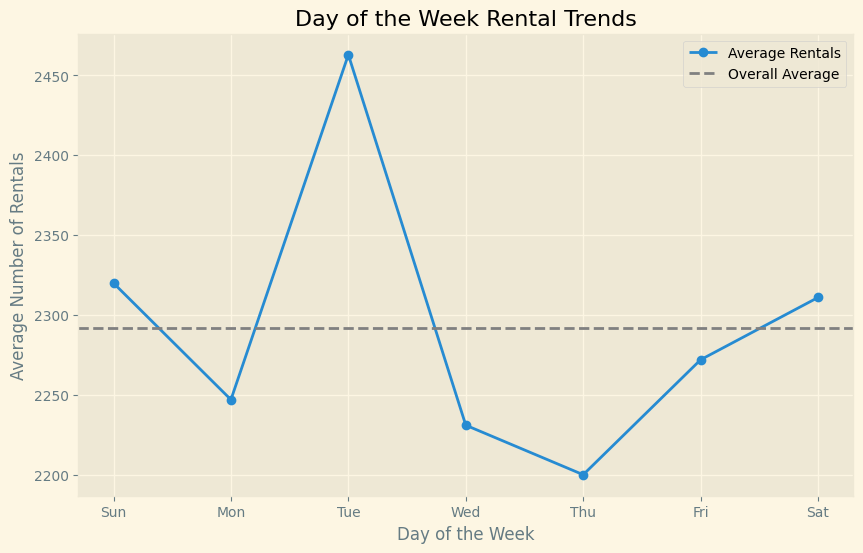

In [15]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

def visualize_day_of_week_rental_trends(conn):
    query = """
    WITH DayOfWeekRental AS (
        SELECT
            DATE_PART('dow', r.rental_date) AS day_of_week,
            COUNT(r.rental_id) AS rental_count
        FROM
            rental r
        GROUP BY
            DATE_PART('dow', r.rental_date)
    ),
    OverallAverage AS (
        SELECT
            AVG(rental_count) AS average_rental_count
        FROM
            DayOfWeekRental
    )
    SELECT
        d.day_of_week,
        d.rental_count,
        CASE
            WHEN d.rental_count > o.average_rental_count THEN 'Higher'
            WHEN d.rental_count < o.average_rental_count THEN 'Lower'
            ELSE 'Equal'
        END AS trend_indicator
    FROM
        DayOfWeekRental d
    CROSS JOIN
        OverallAverage o
    ORDER BY
        d.day_of_week;
    """

    # Connect to the PostgreSQL database
    conn = psycopg2.connect(
        dbname="dvdrental",
        user="root",
        password="root",
        host="postgres",
        port="5432"
    )

    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)
    style.use("Solarize_Light2")

    # Visualization: Day of the Week Rental Trends (Line Chart)
    plt.figure(figsize=(10, 6))
    plt.plot(df['day_of_week'], df['rental_count'], marker='o', label='Average Rentals')
    plt.axhline(y=df['rental_count'].mean(), color='gray', linestyle='--', label='Overall Average')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Number of Rentals')
    plt.title('Day of the Week Rental Trends')
    plt.xticks(df['day_of_week'], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.legend()
    plt.grid(True)
    plt.show()

    # Close the database connection
    conn.close()

# Call the function to visualize day of the week rental trends
visualize_day_of_week_rental_trends(conn)

### **OTHER POSSIBLE ELEMENTS OF CUSTOMER BEHAVIOR THAT CAN BE ANALYZE INCLUDE THE FOLLOWING**


other elements of customer behavior analysis include segmentation for purposes such as personalizaiton. In our case, we may want to identify the top movie categories preferred by each customer segment. An example of this in our case may include creating a query that groups customers by segments and analyzes their genre preferences, contributing to personalized recommendations. The resulting table will include a column for each of the following: customer segment, preferred movie categories, and the percentage distribution of genre preferences within each segment. Here is the query:

```sql
WITH CustomerSegment AS (
    SELECT
        c.customer_id,
        CASE
            WHEN c.activebool = TRUE THEN 'Active'
            ELSE 'Inactive'
        END AS customer_segment,
        fc.category_id AS preferred_genre_id
    FROM
        customer c
    JOIN
        rental r ON c.customer_id = r.customer_id
    JOIN
        inventory i ON r.inventory_id = i.inventory_id
    JOIN
        film_category fc ON i.film_id = fc.film_id
),
PreferredGenres AS (
    SELECT
        cs.customer_id,
        cs.customer_segment,
        c.category_id AS preferred_genre_id
    FROM
        CustomerSegment cs
    JOIN
        category c ON cs.preferred_genre_id = c.category_id
),
SegmentGenreCounts AS (
    SELECT
        customer_segment,
        preferred_genre_id,
        COUNT(*) AS genre_count
    FROM
        PreferredGenres
    GROUP BY
        customer_segment,
        preferred_genre_id
),
SegmentTotalCounts AS (
    SELECT
        customer_segment,
        SUM(genre_count) AS total_count
    FROM
        SegmentGenreCounts
    GROUP BY
        customer_segment
)
SELECT
    sgc.customer_segment,
    c.name AS preferred_genre,
    ROUND((sgc.genre_count::numeric / stc.total_count) * 100, 2) AS percentage_distribution
FROM
    SegmentGenreCounts sgc
JOIN
    SegmentTotalCounts stc ON sgc.customer_segment = stc.customer_segment
JOIN
    category c ON sgc.preferred_genre_id = c.category_id
ORDER BY
    sgc.customer_segment,
    percentage_distribution DESC;
```

we can also examine the seasonality of movie rentals. For instance, during peak rental periods, we can align promotions and marketing campaigns accordingly. In the case of dvdrental database, we can achieve this by creating a query that aggregates rental data by month and calculates average rentals. The resulting table will include a column for each of the following: month, average rental count.
```sql
SELECT
    EXTRACT(MONTH FROM r.rental_date) AS rental_month,
    TO_CHAR(r.rental_date, 'Month') AS month_name,
    AVG(COUNT(r.rental_id)) OVER (PARTITION BY EXTRACT(MONTH FROM r.rental_date)) AS average_rental_count
FROM
    rental r
GROUP BY
    rental_month, month_name
ORDER BY
    rental_month;
```

/tmp/ipykernel_10223/1667320899.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


<Figure size 1000x600 with 0 Axes>

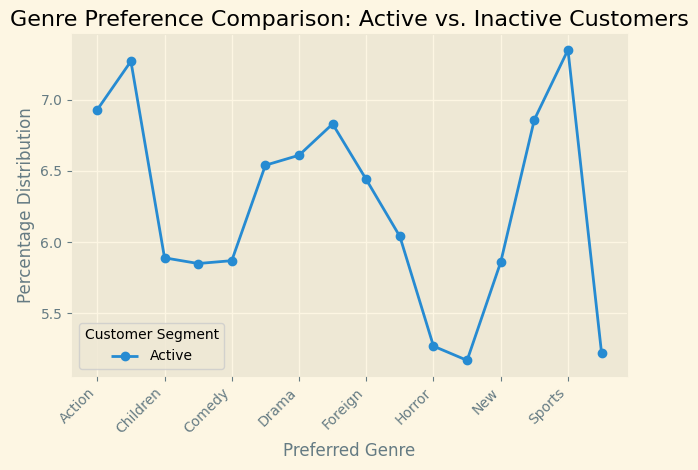

In [2]:
def visualize_genre_preference_over_time(conn):
    query = """
    WITH CustomerSegment AS (
        SELECT
            c.customer_id,
            CASE
                WHEN c.activebool = TRUE THEN 'Active'
                ELSE 'Inactive'
            END AS customer_segment,
            fc.category_id AS preferred_genre_id
        FROM
            customer c
        JOIN
            rental r ON c.customer_id = r.customer_id
        JOIN
            inventory i ON r.inventory_id = i.inventory_id
        JOIN
            film_category fc ON i.film_id = fc.film_id
    ),
    PreferredGenres AS (
        SELECT
            cs.customer_id,
            cs.customer_segment,
            c.category_id AS preferred_genre_id
        FROM
            CustomerSegment cs
        JOIN
            category c ON cs.preferred_genre_id = c.category_id
    ),
    SegmentGenreCounts AS (
        SELECT
            customer_segment,
            preferred_genre_id,
            COUNT(*) AS genre_count
        FROM
            PreferredGenres
        GROUP BY
            customer_segment,
            preferred_genre_id
    ),
    SegmentTotalCounts AS (
        SELECT
            customer_segment,
            SUM(genre_count) AS total_count
        FROM
            SegmentGenreCounts
        GROUP BY
            customer_segment
    )
    SELECT
        sgc.customer_segment,
        c.name AS preferred_genre,
        ROUND((sgc.genre_count::numeric / stc.total_count) * 100, 2) AS percentage_distribution
    FROM
        SegmentGenreCounts sgc
    JOIN
        SegmentTotalCounts stc ON sgc.customer_segment = stc.customer_segment
    JOIN
        category c ON sgc.preferred_genre_id = c.category_id
    ORDER BY
        sgc.customer_segment,
        percentage_distribution DESC;
    """
    
    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)
    
    # Pivot the data to create separate columns for Active and Inactive segments
    pivoted_df = df.pivot(index="preferred_genre", columns="customer_segment", values="percentage_distribution")

    # Plotting
    style.use("Solarize_Light2")
    plt.figure(figsize=(10, 6))
    pivoted_df.plot(kind="line", marker="o")
    plt.xlabel("Preferred Genre")
    plt.ylabel("Percentage Distribution")
    plt.title("Genre Preference Comparison: Active vs. Inactive Customers")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Customer Segment")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function with the database connection
visualize_genre_preference_over_time(conn)

# Close the database connection
conn.close()

/tmp/ipykernel_3418/1292775951.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


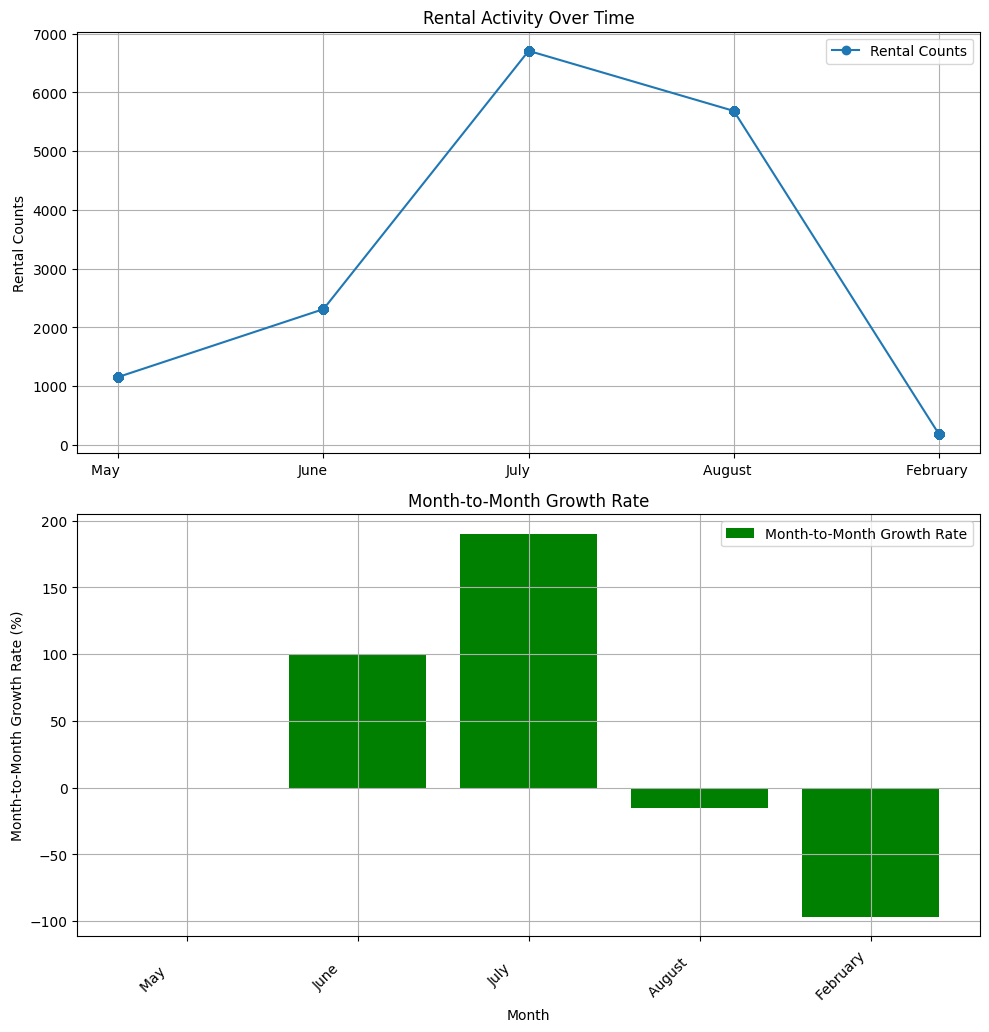

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

def visualize_rental_activity(conn):
    query = """
    WITH MonthlyRentalCounts AS (
        SELECT
            EXTRACT(YEAR FROM rental_date) AS rental_year,
            EXTRACT(MONTH FROM rental_date) AS rental_month,
            COUNT(rental_id) AS rental_count
        FROM
            rental
        GROUP BY
            rental_year, rental_month
    )
    SELECT
        mrc.rental_year,
        mrc.rental_month,
        TO_CHAR(DATE_TRUNC('month', DATE_TRUNC('year', r.rental_date) + INTERVAL '1 month' * (mrc.rental_month - 1)), 'Month') AS month_name,
        mrc.rental_count,
        LAG(mrc.rental_count) OVER (ORDER BY mrc.rental_year, mrc.rental_month) AS prev_month_rental_count
    FROM
        MonthlyRentalCounts mrc
    JOIN
        rental r ON mrc.rental_year = EXTRACT(YEAR FROM r.rental_date) AND mrc.rental_month = EXTRACT(MONTH FROM r.rental_date)
    """
    
    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)
    
    # Calculate month-to-month growth rate
    df['month_to_month_growth'] = ((df['rental_count'] - df['prev_month_rental_count']) / df['prev_month_rental_count']) * 100
    
    # Create the combined plot
    plt.figure(figsize=(10, 10))

    # Line Chart (Average Rental Counts)
    plt.subplot(2, 1, 1)
    plt.plot(df['month_name'], df['rental_count'], marker='o', label='Rental Counts')
    plt.ylabel('Rental Counts')
    plt.title('Rental Activity Over Time')
    plt.grid(True)
    plt.legend()

    # Month-to-Month Growth Visualization
    plt.subplot(2, 1, 2)
    plt.bar(df['month_name'], df['month_to_month_growth'], color='green', label='Month-to-Month Growth Rate')
    plt.xlabel('Month')
    plt.ylabel('Month-to-Month Growth Rate (%)')
    plt.title('Month-to-Month Growth Rate')
    plt.grid(True)
    plt.legend()

    # Customize layout
    plt.tight_layout()
    plt.xticks(rotation=45, ha="right")
    plt.show()
    # save
    plt.savefig('combined_plot.png')

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function with the database connection
visualize_rental_activity(conn)

# Close the database connection
conn.close()

/tmp/ipykernel_10223/3692515745.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


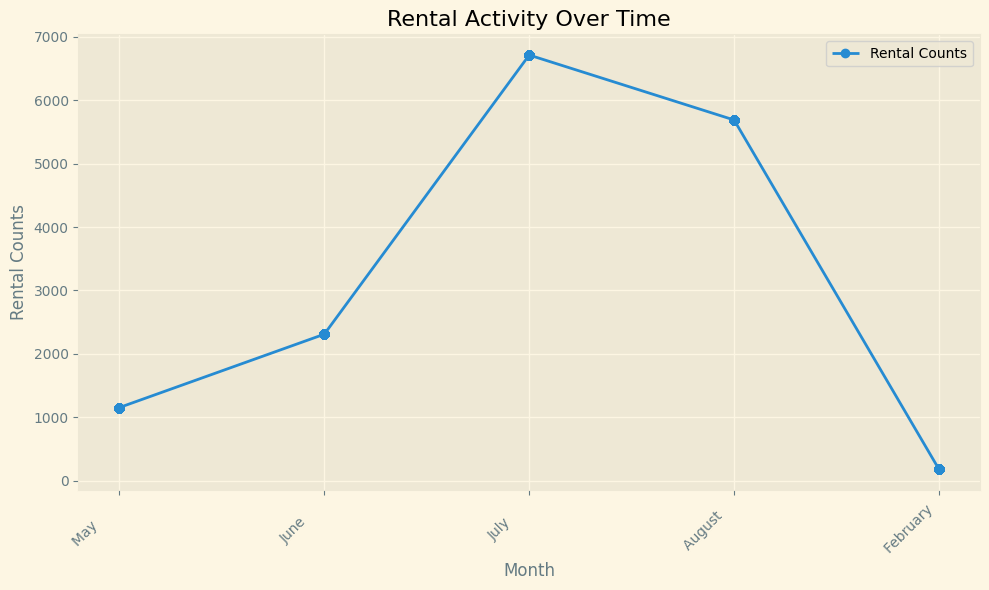

<Figure size 640x480 with 0 Axes>

In [11]:
def visualize_rental_activity(conn, save_path=None):
    query = """
    WITH MonthlyRentalCounts AS (
        SELECT
            EXTRACT(YEAR FROM rental_date) AS rental_year,
            EXTRACT(MONTH FROM rental_date) AS rental_month,
            COUNT(rental_id) AS rental_count
        FROM
            rental
        GROUP BY
            rental_year, rental_month
    )
    SELECT
        mrc.rental_year,
        mrc.rental_month,
        TO_CHAR(DATE_TRUNC('month', DATE_TRUNC('year', r.rental_date) + INTERVAL '1 month' * (mrc.rental_month - 1)), 'Month') AS month_name,
        mrc.rental_count,
        LAG(mrc.rental_count) OVER (ORDER BY mrc.rental_year, mrc.rental_month) AS prev_month_rental_count
    FROM
        MonthlyRentalCounts mrc
    JOIN
        rental r ON mrc.rental_year = EXTRACT(YEAR FROM r.rental_date) AND mrc.rental_month = EXTRACT(MONTH FROM r.rental_date)
    """
    
    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)
    
    # Calculate month-to-month growth rate
    df['month_to_month_growth'] = ((df['rental_count'] - df['prev_month_rental_count']) / df['prev_month_rental_count']) * 100
    
    # Create the combined plot
    plt.figure(figsize=(10, 6))

    # Line Chart (Average Rental Counts)
    plt.plot(df['month_name'], df['rental_count'], marker='o', label='Rental Counts')
    plt.xlabel('Month')
    plt.ylabel('Rental Counts')
    plt.title('Rental Activity Over Time')
    plt.grid(True)
    plt.legend()

    # Customize layout
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    # save image
    if save_path:
        plt.savefig(save_path);

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function with the database connection
visualize_rental_activity(conn, save_path="rental_activity_plot.png")

# Close the database connection
conn.close()

In [2]:
!pip install psycopg2-binary seaborn

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/20/81/4940235d18747f865d47eb38b98f38acc24b39278b12e20a0fdd20e0a132/psycopg2_binary-2.9.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 119.5 kB/s eta 0:00:001m137.8 kB/s eta 0:00:01
  Obtaining dependency information for numpy!=1.24.0,>=1.17 from https://files.pythonhosted.org/packages/32/6a/65dbc57a89078af9ff8bfcd4c0761a50172d90192eaeb1b6f56e5fbf1c3d/numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas>=0.25 from https://files.pythonhosted.org/packages/d0/28/88b81881c056376254618fad622a5e94b5126db8c61157ea1910cd1c040a/pandas-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.1 from https://files.pythonhosted.org/packages/4f/d7/3303f11188122f66c940056f16

/tmp/ipykernel_2356/1245614823.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


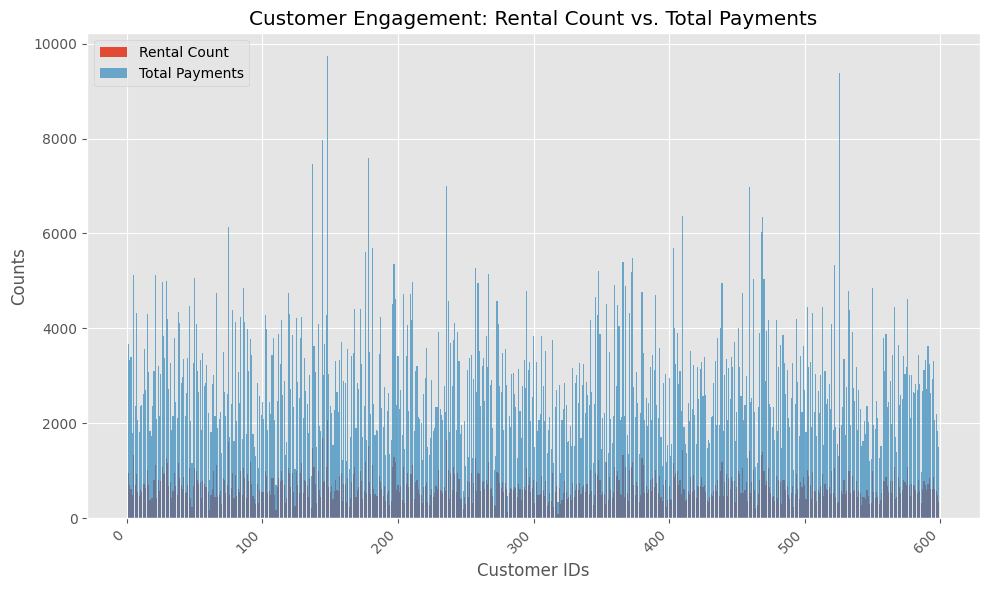

In [3]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

def visualize_customer_engagement(conn):
    query = """
    WITH CustomerLoyalty AS (
        SELECT
            c.customer_id,
            COUNT(r.rental_id) AS rental_count,
            SUM(p.amount) AS total_payments
        FROM
            customer c
        LEFT JOIN
            rental r ON c.customer_id = r.customer_id
        LEFT JOIN
            payment p ON c.customer_id = p.customer_id
        GROUP BY
            c.customer_id
    )
    SELECT
        cl.customer_id,
        cl.rental_count,
        cl.total_payments,
        CASE
            WHEN cl.rental_count >= 100 AND cl.total_payments >= 500 THEN 'High'
            WHEN cl.rental_count >= 50 AND cl.total_payments >= 200 THEN 'Medium'
            ELSE 'Low'
        END AS loyalty_level
    FROM
        CustomerLoyalty cl
    JOIN
        customer c ON cl.customer_id = c.customer_id
    """

    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)
    
    # Set the style for plotting
    style.use("ggplot")

    # Visualization: Bar Chart for Rental Count and Total Payments
    plt.figure(figsize=(10, 6))
    plt.bar(df['customer_id'], df['rental_count'], label='Rental Count')
    plt.bar(df['customer_id'], df['total_payments'], label='Total Payments', alpha=0.7)
    plt.xlabel('Customer IDs')
    plt.ylabel('Counts')
    plt.title('Customer Engagement: Rental Count vs. Total Payments')
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function to visualize customer engagement
visualize_customer_engagement(conn)

# Close the database connection
conn.close()

/tmp/ipykernel_2356/175068329.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_distribution = pd.read_sql_query(query, conn)


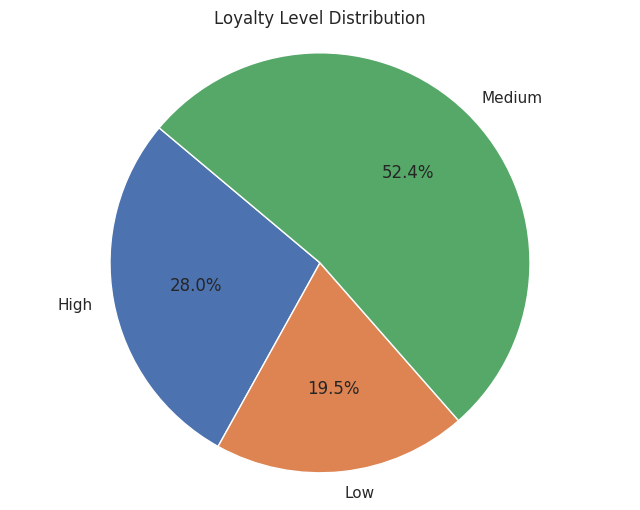

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_loyalty_level_distribution(conn):
    query = """
    WITH CustomerLoyalty AS (
        SELECT
            c.customer_id,
            COUNT(r.rental_id) AS rental_count,
            SUM(p.amount) AS total_payments
        FROM
            customer c
        LEFT JOIN
            rental r ON c.customer_id = r.customer_id
        LEFT JOIN
            payment p ON c.customer_id = p.customer_id
        GROUP BY
            c.customer_id
    ),
    LoyaltyLevels AS (
        SELECT
            customer_id,
            rental_count,
            total_payments,
            CASE
                WHEN rental_count >= 800 AND total_payments >= 2500 THEN 'High'
                WHEN rental_count >= 450 AND total_payments >= 1500 THEN 'Medium'
                ELSE 'Low'
            END AS loyalty_level
        FROM
            CustomerLoyalty
    )
    SELECT
        ll.loyalty_level,
        COUNT(*) AS customer_count
    FROM
        LoyaltyLevels ll
    GROUP BY
        ll.loyalty_level;
    """

    # Execute the query and fetch the results using pandas
    df_distribution = pd.read_sql_query(query, conn)

    # Set the style to "seaborn"
    sns.set(style="whitegrid")

    # Visualization: Pie Chart for Loyalty Level Distribution
    plt.figure(figsize=(8, 6))
    plt.pie(df_distribution['customer_count'], labels=df_distribution['loyalty_level'], autopct='%1.1f%%', startangle=140)
    plt.title('Loyalty Level Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function to visualize loyalty level distribution
visualize_loyalty_level_distribution(conn)

# Close the database connection
conn.close()

/tmp/ipykernel_2356/4084032857.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


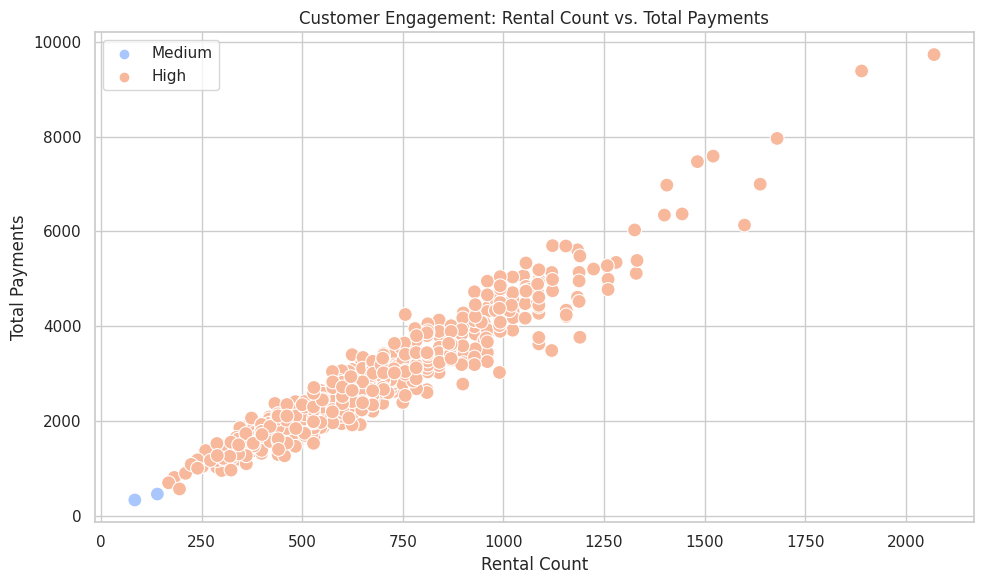

In [5]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_customer_engagement(conn):
    query = """
    WITH CustomerLoyalty AS (
        SELECT
            c.customer_id,
            COUNT(r.rental_id) AS rental_count,
            SUM(p.amount) AS total_payments
        FROM
            customer c
        LEFT JOIN
            rental r ON c.customer_id = r.customer_id
        LEFT JOIN
            payment p ON c.customer_id = p.customer_id
        GROUP BY
            c.customer_id
    )
    SELECT
        cl.customer_id,
        cl.rental_count,
        cl.total_payments,
        CASE
            WHEN cl.rental_count >= 100 AND cl.total_payments >= 500 THEN 'High'
            WHEN cl.rental_count >= 50 AND cl.total_payments >= 200 THEN 'Medium'
            ELSE 'Low'
        END AS loyalty_level,
        AVG(cl.rental_count) OVER () AS avg_rental_count,
        AVG(cl.total_payments) OVER () AS avg_total_payments
    FROM
        CustomerLoyalty cl
    JOIN
        customer c ON cl.customer_id = c.customer_id
    ORDER BY
        loyalty_level DESC;
    """

    # Execute the query and fetch the results using pandas
    df = pd.read_sql_query(query, conn)

    # Set the style to "seaborn"
    sns.set(style="whitegrid")

    # Visualization: Scatter Plot for Rental Count vs. Total Payments
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='rental_count', y='total_payments', data=df, hue='loyalty_level', palette='coolwarm', s=100)
    plt.xlabel('Rental Count')
    plt.ylabel('Total Payments')
    plt.title('Customer Engagement: Rental Count vs. Total Payments')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname="dvdrental",
    user="root",
    password="root",
    host="postgres",
    port="5432"
)

# Call the function to visualize customer engagement
visualize_customer_engagement(conn)

# Close the database connection
conn.close()